In [1]:
import torch, json
import numpy as np
import tensorrt as trt
from torchvision import datasets, models, transforms
from torch2trt import torch2trt
from PIL import Image
# Import matplotlib and configure it for pretty inline plots
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
model = models.mobilenet_v2(pretrained=True)
# Send the model to the GPU 
model.cuda()
# Set layers such as dropout and batchnorm in evaluation mode
model.eval();

In [3]:
with open("imagenet-simple-labels.json") as f:
    labels = json.load(f)

In [4]:
data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

(<matplotlib.image.AxesImage at 0x7f02318128>,
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

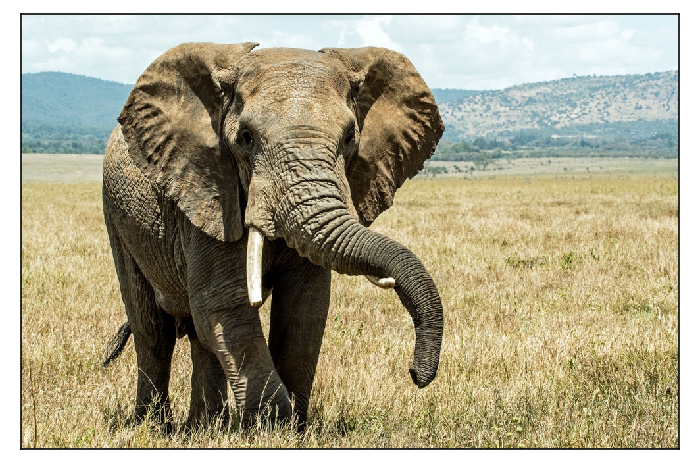

In [5]:
test_image = 'elephant.jpeg'
image = Image.open(test_image)
plt.imshow(image), plt.xticks([]), plt.yticks([])

In [6]:
image = data_transform(image).unsqueeze(0).cuda()

In [7]:
# create example data 
x = torch.ones((1, 3, 224, 224)).cuda()

# convert to TensorRT feeding sample data as input
model_trt = torch2trt(model, [x])

In [8]:
out = model(image)
out_trt = model_trt(image)
# Find the predicted class
print("Predicted model class is: {}".format(labels[out.argmax()]))
print("Predicted model_trt class is: {}".format(labels[out_trt.argmax()]))

Predicted model class is: African bush elephant
Predicted model_trt class is: African bush elephant


In [28]:
import time
fps = np.zeros(200)
with torch.no_grad(): # speed it up by not computing gradients since we don't need them for inference
    for i in range(200):
        t0 = time.time()
        out = model(image)
        fps[i] = 1 / (time.time() - t0)

fps_trt = np.zeros(200)
with torch.no_grad(): # speed it up by not computing gradients since we don't need them for inference
    for i in range(200):
        t0 = time.time()
        out = model_trt(image)
        fps_trt[i] = 1 / (time.time() - t0)

Text(0.5, 1.0, 'PyTorch -> TensorRT')

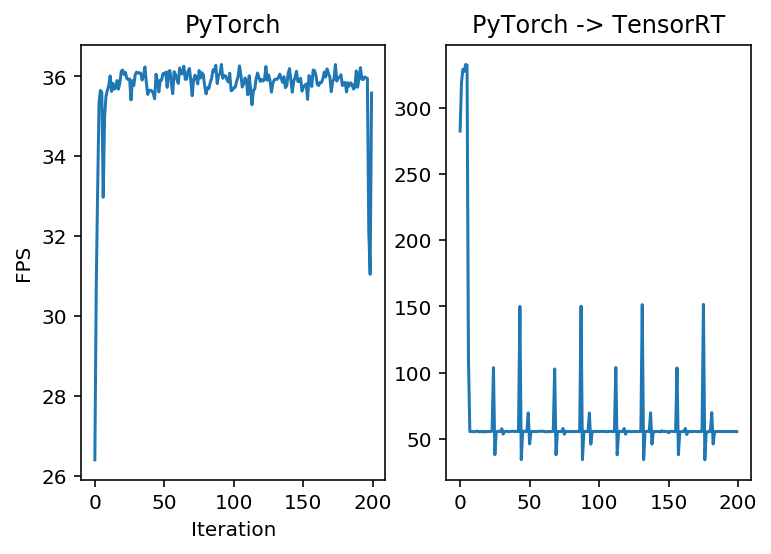

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(fps)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('FPS')
ax1.set_title('PyTorch')
ax2.plot(fps_trt)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('FPS')
ax2.set_title('PyTorch -> TensorRT')